## Solving quadratic unconstrained binary optimization (QUBO) problems with Quantum Approximate Optimization Algorithm (QAOA)

The QAOA circuit consists of a cost Hamiltonian and a mixer Hamiltonian. 

The cost Hamiltonian defines our problem and the mixer Hamiltonian can be thought as a function that allows us to explore different solutions to the problem. 

The variational parameters for the cost and mixer Hamiltonians are optimized using a classical computer. 

In this code, we convert the QUBO matrix to an Ising Hamiltonian.

In [21]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit import ParameterVector

from qiskit.visualization import plot_distribution

from scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from gurobi_optimods.qubo import solve_qubo

from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp

In [22]:
# Define the backend used
backend = AerSimulator(method='statevector')

We want to convert the QUBO matrix to an Ising Hamiltonian and use the Ising Hamiltonian as a cost Hamiltonian. This is done by making a transformation to the QUBO matrix elements,
$$x_i \rightarrow \frac{1-z_i}{2}.$$

With the following function, we get the operators that we can apply to the quantum circuit.

In [23]:
def convert_qubo_to_ising(qubo):
    # Number of qubits
    n = len(qubo)

    # Calculate the offset also, this is not important for the optimization
    offset = 0
    
    operator_list = []

    for i in range(n):
        for j in range(i, n):
            # Initialize the Pauli operator with all I's
            pauli_operator = list("I"*n)
            
            if i == j:
                pauli_operator[i] = "Z"
                ising_value = -(1/2)*np.sum(qubo[i])
            else:
                pauli_operator[i] = "Z"
                pauli_operator[j] = "Z"
                ising_value = (1/2)*qubo[i][j]

            if not ising_value == 0:
                ising_pauli_op = (''.join(pauli_operator), ising_value)
                operator_list.append(ising_pauli_op)

            offset += (1/2)*qubo[i][j]

    operators = SparsePauliOp.from_list(operator_list)

    return operators

In [24]:
def initialize_circuit(n):
    qc = QuantumCircuit(n)

    # Usually in QAOA the quantum circuit is initialized with a Hadamard gate applied to every qubit
    qc.h(range(n))

    qc.barrier()

    return qc

In [25]:
def apply_cost_layer(qc, n, qubo, gamma): 
    cost_layer = PauliEvolutionGate(qubo, gamma)
    qc.append(cost_layer, range(n))
    
    qc.barrier()

The mixer Hamiltonian is the basic QAOA mixer:
$$\sum_i^n R_{X_i}(\beta_p)$$

In [26]:
def apply_mixer_layer(qc, n, beta):
    # The normal QAOA mixer is a RX gate applied to every qubit
    for i in range(n):
        qc.rx(2*beta, i)
    
    qc.barrier()

In [27]:
def apply_qaoa_layer(qc, n, layers, qubo, parameters):
    i = 0
    while i < layers*2:
        # Apply cost layer
        apply_cost_layer(qc, n, qubo, parameters[i])
        # Apply mixer layer
        apply_mixer_layer(qc, n, parameters[i+1])

        # New QAOA layer
        i += 2

In [28]:
def initialize_parameters(layers):
    theta = []
    
    for i in range(layers):
        # Initialize a parameter for the "gamma" variable
        initial_gamma = 2 * np.pi
        theta.append(initial_gamma)
        # Initialize a parameter for the "beta" variable
        initial_beta = np.pi
        theta.append(initial_beta)
    
    return theta

In [29]:
# Calculate the expectation value using the QUBO matrix. We are trying to minimize this expectation value.
def calculate_expectation_value(theta, qc, qubo, parameters, exp_value_list, shots=10000):
    # Assign the gammas and the betas to the circuit
    qc_assigned_parameters = qc.assign_parameters({parameters:theta})
    # Transpile the circuit for the backend and measure the qubits
    qc_assigned_parameters.measure_all()
    qc_transpiled = transpile(qc_assigned_parameters, backend)

    # Run the circuit on the backend
    result = backend.run(qc_transpiled, shots=shots).result()

    # Save the counts to a variable
    counts = result.get_counts()

    exp_value = 0

    for bitstring in counts.keys():
        # Calculate the occurrence of a bitstring with respect to the number of shots
        occurrence_bitstring = counts[bitstring] / shots

        # Calculate the QUBO result of a bitstring
        qubo_value = 0
        for i in range(len(qubo)):
            for j in range(len(qubo)):
                if i == j:
                    qubo_value += qubo[i][j]*int(bitstring[i])
                else:
                    qubo_value += qubo[i][j]*int(bitstring[i])*int(bitstring[j])

        # Expectation values of all bitstrings are summed
        exp_value += occurrence_bitstring * qubo_value
    
    exp_value_list.append(exp_value)
    
    return exp_value


In [30]:
def optimize_parameters(qc, qubo, parameters, theta):
    # Save the expectation values the optimization gives us so that we can visualize the optimization
    exp_value_list = []

    # Here we can change the classical optimization method etc.
    min_minimized_optimization = minimize(calculate_expectation_value, theta, method="Powell", args=(qc, qubo, parameters, exp_value_list))

    # Save the objective value the optimization finally gives us
    minimum_objective_value = min_minimized_optimization.fun
    min_exp_value_list = exp_value_list

    return min_minimized_optimization.x, minimum_objective_value, min_exp_value_list

In [31]:
def qaoa(qubo, layers):
    # Number of qubits = length of the QUBO matrix
    n = len(qubo)

    # Initialize circuit
    qc = initialize_circuit(n)

    # Initialize parameters
    parameters = ParameterVector('theta', 2*layers)
    theta = initialize_parameters(layers)

    # Convert the QUBO matrix to the Ising Hamiltonian
    ising = convert_qubo_to_ising(qubo)

    # Apply the QAOA layers
    apply_qaoa_layer(qc, n, layers, ising, parameters)

    # Optimize the parameters
    theta, minimum_objective_value, exp_value_list = optimize_parameters(qc, qubo, parameters, theta)
    
    return qc, theta, minimum_objective_value, exp_value_list, parameters

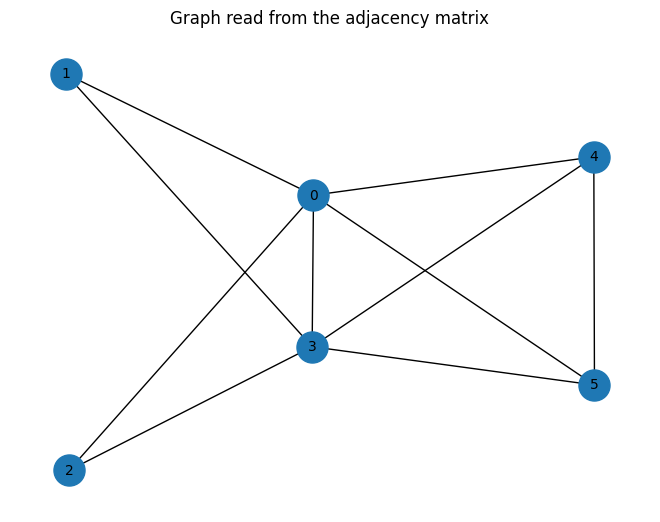

In [32]:
# Define MaxCut problem with an adjacency matrix and turn it into a QUBO matrix

adjacency_matrix = [[0, 1, 1, 1, 1, 1],
                    [1, 0, 0, 1, 0, 0],
                    [1, 0, 0, 1, 0, 0],
                    [1, 1, 1, 0, 1, 1],
                    [1, 0, 0, 1, 0, 1],
                    [1, 0, 0, 1, 1, 0]]

#adjacency_matrix = [[0, 1, 1, 1, 1, 1],
#                    [1, 0, 1, 1, 1, 1],
#                    [1, 1, 0, 1, 1, 1],
#                    [1, 1, 1, 0, 1, 1],
#                    [1, 1, 1, 1, 0, 1],
#                    [1, 1, 1, 1, 1, 0]]

#adjacency_matrix = [[0, 1, 0, 1, 0, 0, 0, 0],
#                    [1, 0, 1, 1, 0, 0, 0, 0],
#                    [0, 1, 0, 0, 0, 0, 1, 0],
#                    [1, 1, 0, 0, 0, 1, 0, 0],
#                    [0, 0, 0, 0, 0, 1, 0, 0],
#                    [0, 0, 0, 1, 1, 0, 0, 0],
#                    [0, 0, 1, 0, 0, 0, 0, 1],
#                    [0, 0, 0, 0, 0, 0, 1, 0]]

#adjacency_matrix = [[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
#                    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]]

graph = nx.Graph()
vertex_number = len(adjacency_matrix)
vertex_list = []
for i in range(vertex_number):
    vertex_list.append(i)
    for j in range(vertex_number):
        if adjacency_matrix[i][j] == 1:
            graph.add_edge(i, j)

num_nodes = graph.number_of_nodes()
Q = np.eye(num_nodes)

for i in range(len(adjacency_matrix[0])):
    sum = 0
    for j in range(len(adjacency_matrix[0])):
        sum = sum + adjacency_matrix[i][j]
        if adjacency_matrix[i][j] == 1 and not i == j:
            Q[i][j] = 1
    Q[i][i] = -sum

edge_list = list(graph.edges())
pos = nx.spring_layout(graph)
nx.draw(graph, pos, with_labels=True, node_size=500, font_size=10)
plt.title("Graph read from the adjacency matrix")
plt.show()

In [33]:
# Run the QAOA
qc, theta, minimum_objective_value, exp_value_list, parameters = qaoa(Q, 2)

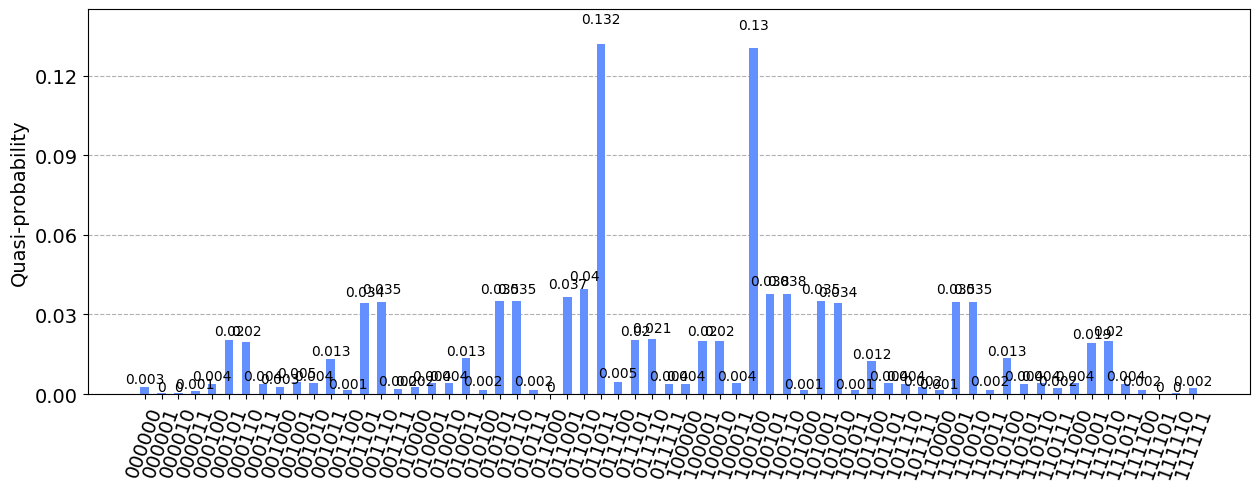

In [34]:
qc_assigned_parameters = qc.assign_parameters({parameters:theta})
qc_transpiled = transpile(qc_assigned_parameters, backend=backend)
qc_transpiled.measure_all()

counts = backend.run(qc_transpiled, shots=50000).result().get_counts()

plot_distribution(counts, figsize=(15, 5))

In [35]:
highest_possible_solution = 0
max_count = 0
for key, count in counts.items():
    if count > max_count:
        max_count = count
        highest_possible_solution = key
print(f"Highest possible solution: {highest_possible_solution}")

# Convert string to array
X = np.fromstring(highest_possible_solution, np.int8) - 48

# Calculate the result using the highest possible solution
E = X.T @ Q @ X

print(f"Result: {E}")

Highest possible solution: 011011
Result: -8.0


C:\Users\tpihkako19\AppData\Local\Temp\ipykernel_2756\1529694762.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  X = np.fromstring(highest_possible_solution, np.int8) - 48


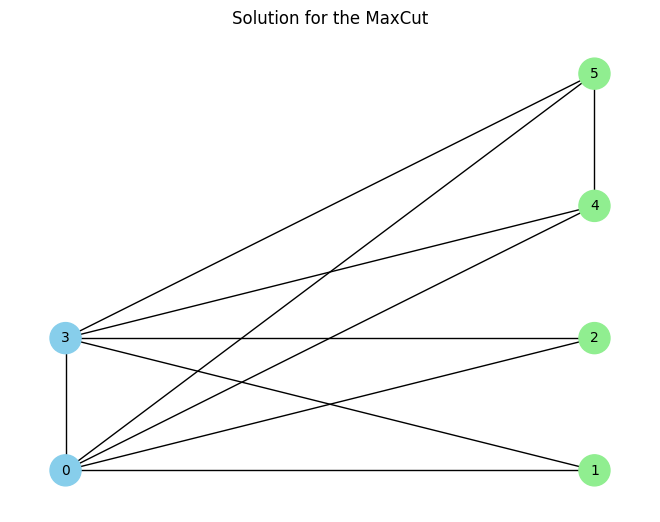

In [36]:
graph = nx.Graph()
group_1 = []
group_2 = []
vertex_number = len(highest_possible_solution)
for i in range(vertex_number):
    if highest_possible_solution[i] == "0":
        group_1.append(i)
    elif highest_possible_solution[i] == "1":
        group_2.append(i)
    else:
        print("No valid solution")
graph.add_nodes_from(group_1, bipartite=0)
graph.add_nodes_from(group_2, bipartite=1)
graph.add_edges_from(edge_list)
pos = {}
pos.update((n, (1, i)) for i, n in enumerate(group_1))
pos.update((n, (2, i)) for i, n in enumerate(group_2))
nx.draw(graph, pos, with_labels=True, node_size=500, font_size=10, node_color=['skyblue'] * len(group_1) + ['lightgreen'] * len(group_2))
plt.title("Solution for the MaxCut")
plt.show()

Solve using a classical solver

In [37]:
result = solve_qubo(Q)

New QUBO solution found with objective 0.0
New QUBO solution found with objective -8.0


Plot the optimizer performance

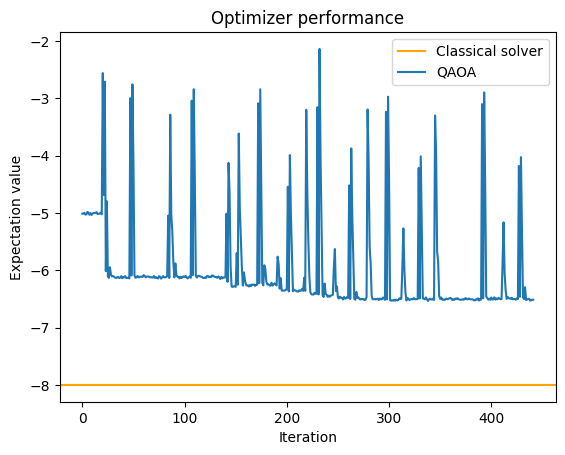

In [38]:
plt.title('Optimizer performance')
plt.xlabel('Iteration')
plt.ylabel('Expectation value')
plt.axhline(y=result.objective_value, color='orange', label='Classical solver')
plt.plot(exp_value_list, label='QAOA')
plt.legend()
plt.show()

In [39]:
print(f'Minimum objective value: {minimum_objective_value}')

Minimum objective value: -6.529699999999999


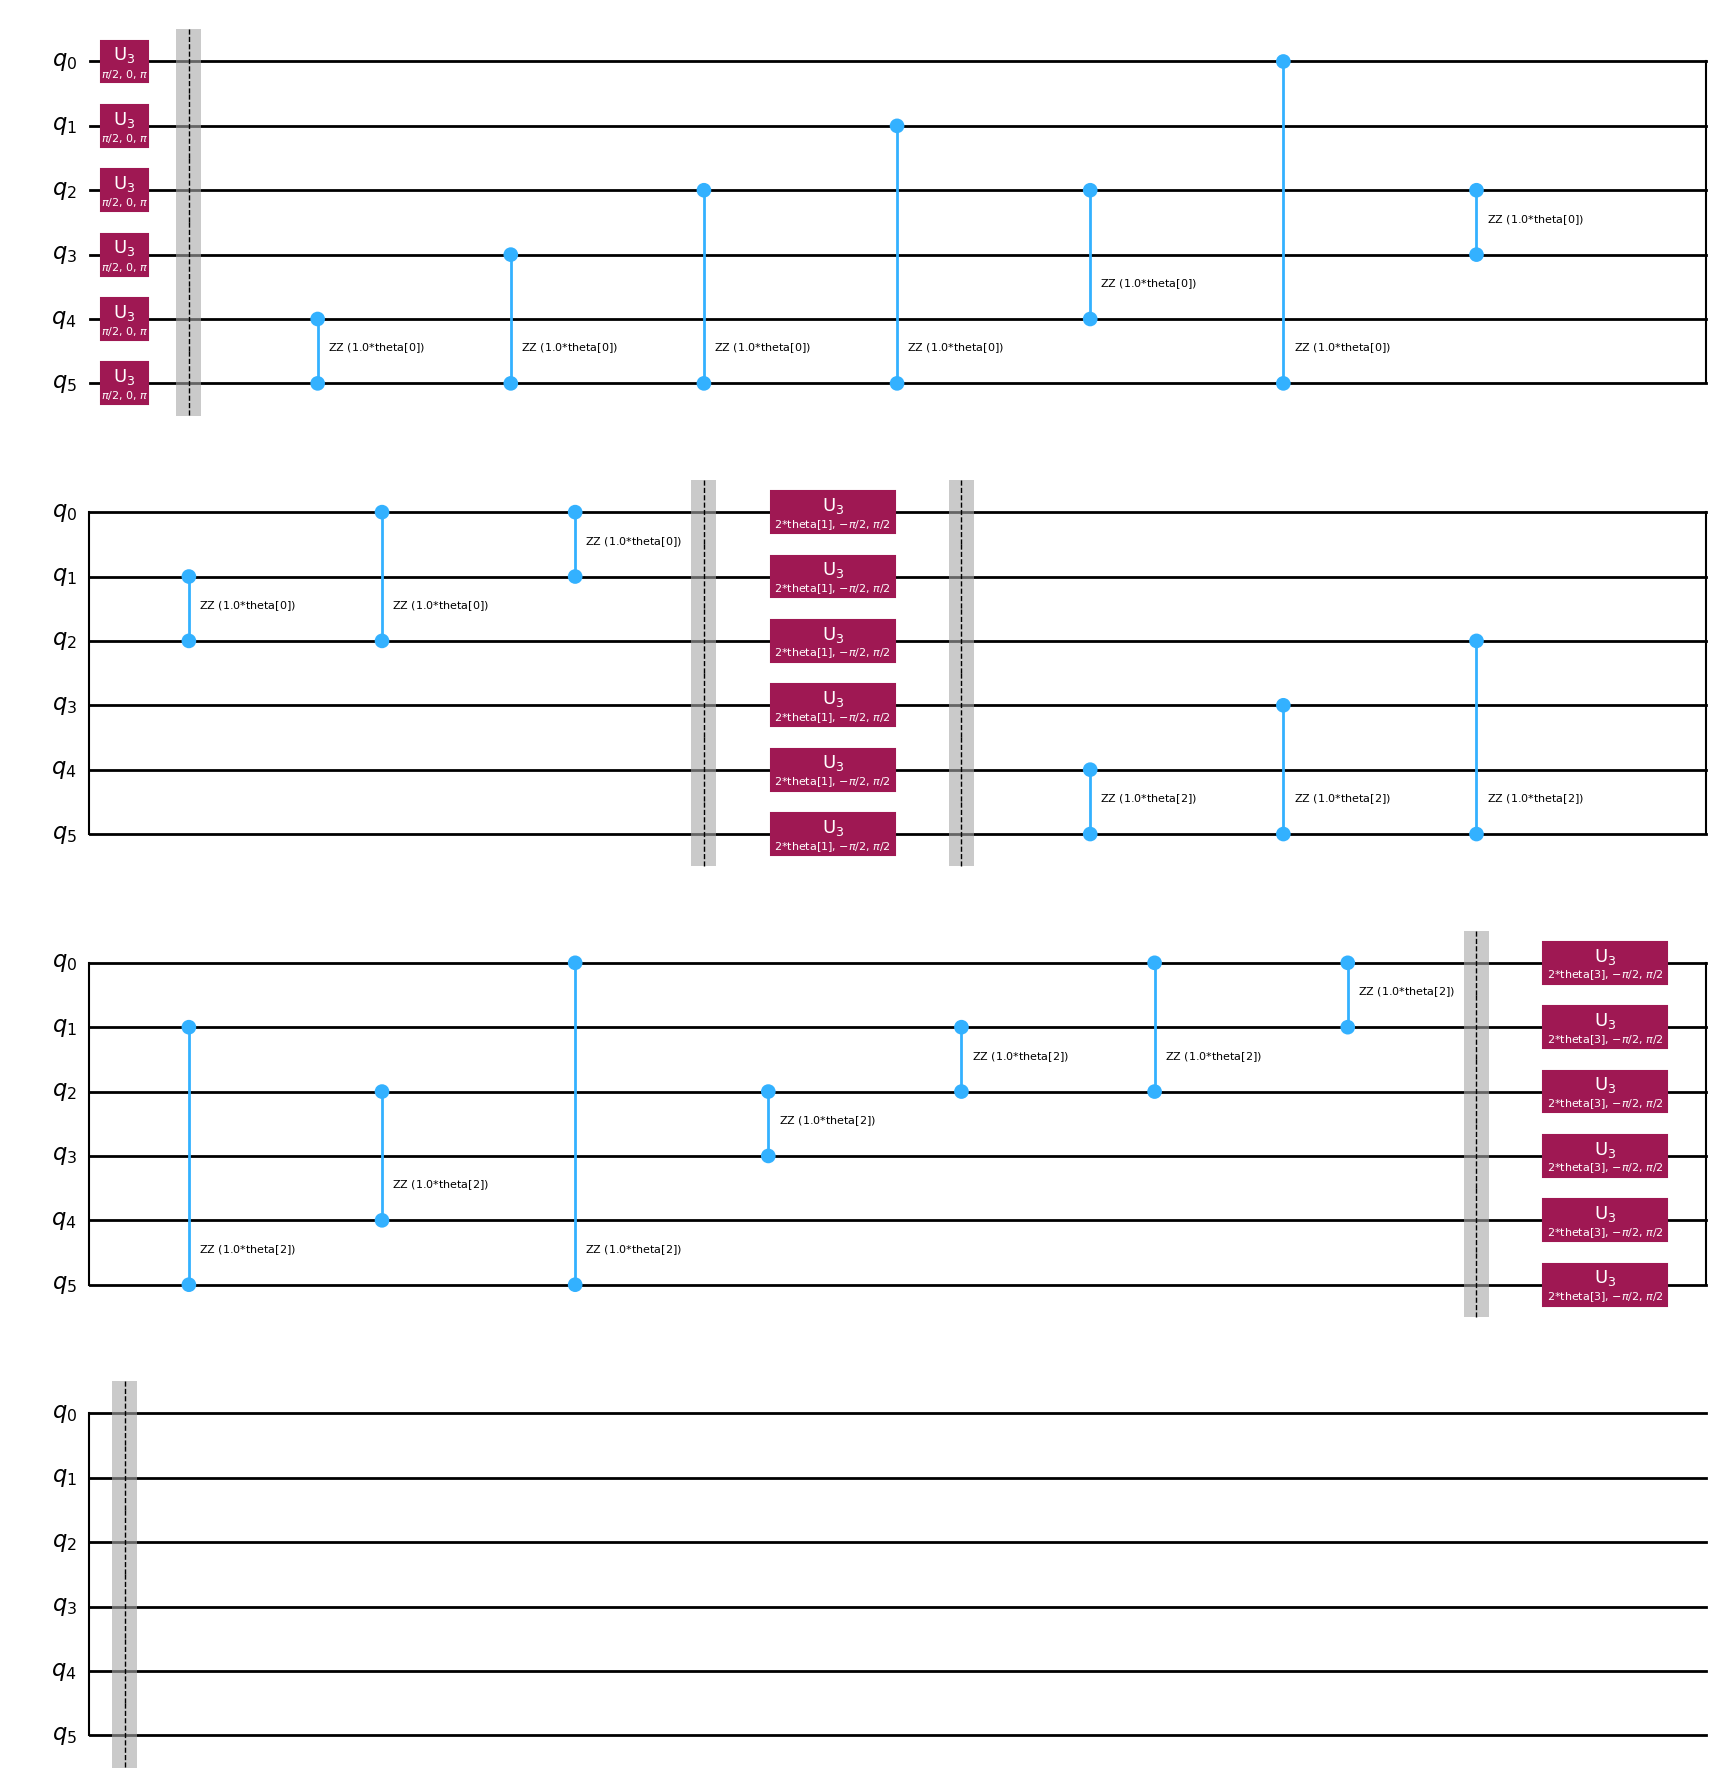

In [40]:
qc.decompose(reps=2).draw(output="mpl", style="iqp")